In [25]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

def normal_cdf(u):
    return norm.cdf(u)

# Example usage
u = 1.96
result = normal_cdf(u)
print(f"Φ({u}) ≈ {result:.4f}")

def med(m,r):
    return -0.152+0.859*m-1.803*np.log(r+25)

Φ(1.96) ≈ 0.9750


In [11]:
np.arange(0.1,2,0.1)


array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

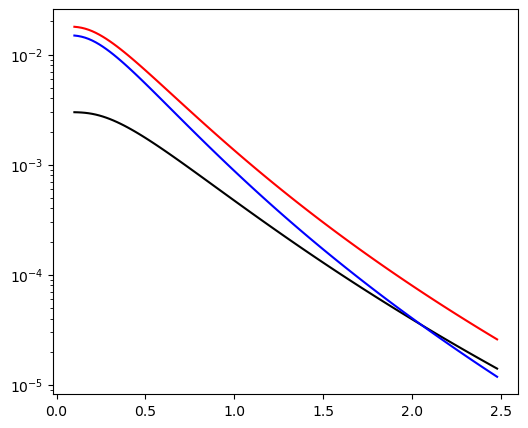

In [22]:
ex_annual = []

f1_ex = []
f2_ex = []


for pga in np.arange(0.1,2.5,0.02):
    f1 = 0.003 * (1-stats.norm.cdf((np.log(pga)-med(7.5,20))/0.57))
    f2 = 0.015 * (1-stats.norm.cdf((np.log(pga)-med(6.6,10))/0.57))

    f1_ex.append(f1)
    f2_ex.append(f2)
    ex_annual.append(f1+f2)

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(6,5))
axs.semilogy(np.arange(0.1,2.5,0.02), f1_ex,'k')
axs.semilogy(np.arange(0.1,2.5,0.02), f2_ex,'b')
axs.semilogy(np.arange(0.1,2.5,0.02), ex_annual,'r')

plt.show()

In [1]:
%matplotlib
from obspy.clients.fdsn import Client
from gphs445_utilities.plot_event import get_geonet_waveforms

client = Client("GEONET")
event = client.get_events(eventid="2019p304574")[0]
# Lets just use the five closest weak motion stations
clean_event = event.copy()
clean_event.picks = [
    p for p in sorted(event.picks, key=lambda p: p.time) 
    if p.waveform_id.channel_code[0] != "B"][0:5]

# We want to remove the amplitudes already picked, and magnitudes so that we can overwrite them with our own.
clean_event.amplitudes = []
clean_event.station_magnitudes = []

st = get_geonet_waveforms(clean_event, all_components=True)
st = st.detrend().taper(0.05)
#st.plot()  # For some reason on Windows I need to plot in this first cell to get later plots to work.
# We need to response information for the stations so that we can correct
# the repsonse and simulate a wood anderson instrument.
bulk = [
    (p.waveform_id.network_code, p.waveform_id.station_code, 
     p.waveform_id.location_code, p.waveform_id.channel_code[0:-1] + "?", 
     p.time - 60, p.time + 200) for p in clean_event.picks]
inv = client.get_stations_bulk(bulk, level="response")

Using matplotlib backend: <object object at 0x104332460>


In [2]:
paz_WA = {'poles': [-6.283 + 4.7124j, -6.283 - 4.7124j],
          'zeros': [0 + 0j], 'gain': 1.0, 'sensitivity': 2080}
st_wa = st.copy()
st_wa = st_wa.remove_response(inv, "DISP")
st_wa = st_wa.simulate(paz_remove=None, paz_simulate=paz_WA)

In [3]:
import matplotlib.pyplot as plt
from gphs445_utilities.seismic_picker import SeismicPicker

picker = SeismicPicker(st_wa, event_in=clean_event)
event_out = SeismicPicker(st_wa, event_in=clean_event).pick()
print(event_out)

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button
Event:	2019-04-23T16:37:10.033368Z | -40.260, +175.967 | 4.79 M  | manual

	            resource_id: ResourceIdentifier(id="smi:nz.org.geonet/2019p304574")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='WEL(GNS_Primary)', author='scevent@kseqp02.geonet.org.nz', creation_time=UTCDateTime(2019, 4, 23, 16, 37, 31, 211115))
	    preferred_origin_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin/20190423173919.723583.55047")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin/20190423173919.723583.55047/netMag/M")
	                   ---------
	     event_descriptions: 1 Elements
	  

In [4]:
event_out

Event:	2019-04-23T16:37:10.033368Z | -40.260, +175.967 | 4.79 M  | manual

	            resource_id: ResourceIdentifier(id="smi:nz.org.geonet/2019p304574")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='WEL(GNS_Primary)', author='scevent@kseqp02.geonet.org.nz', creation_time=UTCDateTime(2019, 4, 23, 16, 37, 31, 211115))
	    preferred_origin_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin/20190423173919.723583.55047")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin/20190423173919.723583.55047/netMag/M")
	                   ---------
	     event_descriptions: 1 Elements
	                  picks: 5 Elements
	                origins: 1 Elements
	             magnitudes: 3 Elements

In [6]:
event_picked = event_out.copy()
# Quick plot to check that the picks are recorded in the right place
SeismicPicker(st_wa, event_picked).show()

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button


In [7]:
for amplitude in event_picked.amplitudes:
    if amplitude.type != "END":
        print("Amplitude: {0:.2g} m".format(amplitude.generic_amplitude))